<a href="https://colab.research.google.com/github/jaredlan1/getting_started_with_ML/blob/main/Hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchdiffeq


In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# If torchdiffeq isn't installed, uncomment:
# !pip install torchdiffeq

from torchdiffeq import odeint

# Reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


device: cuda


In [3]:
def generatetrajectories(ntraj, tsteps, A, trainflag):

    nx, nz = A.shape
    nt = len(tsteps)

    if trainflag:
        z1 = np.random.uniform(low=-1.5, high=0.5, size=ntraj)
        z2 = np.random.uniform(low=-1, high=1, size=ntraj)
    else:
        z1 = np.random.uniform(low=-1.5, high=1.5, size=ntraj)
        z2 = np.random.uniform(low=-1, high=1, size=ntraj)
    Z0 = np.column_stack((z1, z2))  # ntraj x nz

    Z = np.zeros((ntraj, nt, nz))

    def zode(t, z):
        return [z[1], z[0] - z[0]**3]

    for i in range(ntraj):
        sol = solve_ivp(zode, (tsteps[0], tsteps[-1]), Z0[i, :], t_eval=tsteps)
        Z[i, :, :] = sol.y.T

    # map to high dimensional space
    X = np.zeros((ntraj, nt, nx))
    for i in range(nt):
        X[:, i, :] = Z[:, i, :]**3 @ A.T

    return X


def getdata(ntrain, ntest, ncol, t_train, t_test):

    nz = 2
    nx = 128

    A = np.random.normal(size=(nx, nz))

    Xtrain = generatetrajectories(ntrain, t_train, A, trainflag=True)
    Xtest  = generatetrajectories(ntest,  t_test,  A, trainflag=False)

    # collocation points
    z1 = np.random.uniform(low=0.5, high=1.5, size=ncol)
    z2 = np.random.uniform(low=-1, high=1, size=ncol)
    Zcol = np.column_stack((z1, z2))  # ncol x nz
    hZ = np.column_stack((Zcol[:, 1], Zcol[:, 0] - Zcol[:, 0]**3))
    fcol = np.zeros((ncol, nx))
    for i in range(ncol):
        fcol[i, :] = hZ[[i], :] @ (3 * A * Zcol[i, :].T**2).T
    Xcol = Zcol**3 @ A.T

    return Xtrain, Xtest, Xcol, fcol, A


def true_encoder(X, A):  # X is npts * nt * nx
    Z3 = X @ np.linalg.pinv(A).T  # pinv is nz x nx
    return np.sign(Z3) * np.abs(Z3)**(1/3)


In [4]:
# time discretization (match HW)
nt_train = 11
nt_test  = 21
t_train = np.linspace(0.0, 1.0, nt_train)
t_test  = np.linspace(0.0, 1.0, nt_test)

# dataset sizes (you will likely increase ntrain/ncol)
ntrain = 600        # start ~600; bump later if needed
ntest  = 100
ncol   = 10000      # start ~10k; reduce if slow on CPU

Xtrain, Xtest, Xcol, fcol, Amap = getdata(ntrain, ntest, ncol, t_train, t_test)

print("Xtrain:", Xtrain.shape)  # (ntrain, nt_train, 128)
print("Xtest: ", Xtest.shape)   # (ntest,  nt_test,  128)
print("Xcol:  ", Xcol.shape)    # (ncol, 128)
print("fcol:  ", fcol.shape)    # (ncol, 128)


Xtrain: (600, 11, 128)
Xtest:  (100, 21, 128)
Xcol:   (10000, 128)
fcol:   (10000, 128)


In [5]:
Xtrain_t = torch.tensor(Xtrain, dtype=torch.float64, device=device)  # (ntrain, Ttrain, 128)
Xtest_t  = torch.tensor(Xtest,  dtype=torch.float64, device=device)  # (ntest,  Ttest,  128)
Xcol_t   = torch.tensor(Xcol,   dtype=torch.float64, device=device)  # (ncol, 128)
fcol_t   = torch.tensor(fcol,   dtype=torch.float64, device=device)  # (ncol, 128)

t_train_t = torch.tensor(t_train, dtype=torch.float64, device=device)  # (Ttrain,)
t_test_t  = torch.tensor(t_test,  dtype=torch.float64, device=device)  # (Ttest,)


In [6]:
class MLP(nn.Module):
    def __init__(self, dims, act=nn.ReLU):
        super().__init__()
        layers = []
        for i in range(len(dims)-2):
            layers += [nn.Linear(dims[i], dims[i+1]), act()]
        layers += [nn.Linear(dims[-2], dims[-1])]  # linear output
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class PINODE(nn.Module):
    def __init__(self, nx=128, nz=2):
        super().__init__()
        # encoder/decoder per supplement (3 layers, hidden 256)
        self.enc = MLP([nx, 256, 256, nz], act=nn.ReLU)
        self.dec = MLP([nz, 256, 256, nx], act=nn.ReLU)
        # latent dynamics per supplement (3 layers, hidden 128)
        self.h   = MLP([nz, 128, 128, nz], act=nn.ReLU)

    def encode(self, x):
        return self.enc(x)

    def decode(self, z):
        return self.dec(z)

    def f(self, t, z):
        return self.h(z)

model = PINODE(nx=128, nz=2).double().to(device)
print(model)


PINODE(
  (enc): MLP(
    (net): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (dec): MLP(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=128, bias=True)
    )
  )
  (h): MLP(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
    )
  )
)


In [7]:
def recon_and_pred_losses(model, x_traj, t):
    """
    x_traj: (B, T, 128)
    t:      (T,)
    """
    B, Tsteps, nx = x_traj.shape
    x0 = x_traj[:, 0, :]                      # (B, nx)

    # latent rollout
    z0 = model.encode(x0)                     # (B, 2)
    zt = odeint(model.f, z0, t)               # (T, B, 2)
    xhat = model.decode(zt.reshape(-1, 2)).reshape(Tsteps, B, nx).permute(1, 0, 2).contiguous()

    pred = torch.mean((xhat - x_traj)**2)

    # reconstruction for all snapshots
    zsnap = model.encode(x_traj.reshape(-1, nx))
    xrec  = model.decode(zsnap).reshape(B, Tsteps, nx)
    recon = torch.mean((xrec - x_traj)**2)

    return recon, pred

def physics_loss(model, x_col, f_col):
    """
    Enforce: J_enc(x) * dx/dt = h(enc(x))
    x_col: (Bcol, 128)
    f_col: (Bcol, 128)  [given by your file]
    """
    x_col = x_col.requires_grad_(True)
    z = model.encode(x_col)                   # (Bcol, 2)

    # Chain rule dz/dt = J_enc(x) * f(x)
    dzdt_chain = []
    for j in range(2):
        grad_zj = torch.autograd.grad(
            outputs=z[:, j].sum(),
            inputs=x_col,
            create_graph=True,
            retain_graph=True
        )[0]                                  # (Bcol, 128)
        dzdt_chain.append((grad_zj * f_col).sum(dim=1, keepdim=True))
    dzdt_chain = torch.cat(dzdt_chain, dim=1) # (Bcol, 2)

    dzdt_latent = model.h(z)                  # (Bcol, 2)
    return torch.mean((dzdt_chain - dzdt_latent)**2)


In [8]:
def train(model, Xtrain_t, Xcol_t, fcol_t, t_train_t,
          epochs=400, nbatches=100,
          w_recon=1.0, w_pred=1.0, w_phys=1.0,
          lr=1e-4):

    ntrain = Xtrain_t.shape[0]
    ncol   = Xcol_t.shape[0]

    bs_traj = max(1, ntrain // nbatches)
    bs_col  = max(1, ncol   // nbatches)

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for ep in range(1, epochs+1):
        model.train()

        perm_tr = torch.randperm(ntrain, device=Xtrain_t.device)
        perm_co = torch.randperm(ncol,   device=Xcol_t.device)

        running = []

        for b in range(nbatches):
            idx_tr = perm_tr[b*bs_traj:(b+1)*bs_traj]
            idx_co = perm_co[b*bs_col:(b+1)*bs_col]
            if idx_tr.numel() == 0 or idx_co.numel() == 0:
                continue

            x_traj = Xtrain_t[idx_tr]          # (B, T, 128)
            x_col  = Xcol_t[idx_co]            # (Bcol, 128)
            f_col  = fcol_t[idx_co]            # (Bcol, 128)

            recon, pred = recon_and_pred_losses(model, x_traj, t_train_t)
            phys = physics_loss(model, x_col, f_col)

            loss = w_recon*recon + w_pred*pred + w_phys*phys

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            running.append([loss.item(), recon.item(), pred.item(), phys.item()])

        if ep % 10 == 0:
            L = np.mean(running, axis=0)
            print(f"ep {ep:4d} | total {L[0]:.4e} | recon {L[1]:.4e} | pred {L[2]:.4e} | phys {L[3]:.4e}")

    return model


In [9]:
# If training is unstable, start w_phys=0.1 for 50 epochs then increase to 1.0.
model = train(
    model,
    Xtrain_t=Xtrain_t,
    Xcol_t=Xcol_t,
    fcol_t=fcol_t,
    t_train_t=t_train_t,
    epochs=400,
    nbatches=100,
    w_recon=1.0,
    w_pred=1.0,
    w_phys=1.0,
    lr=1e-4
)


ep   10 | total 1.9572e-01 | recon 3.4739e-02 | pred 1.2969e-01 | phys 3.1296e-02
ep   20 | total 9.1614e-02 | recon 1.3651e-02 | pred 5.9909e-02 | phys 1.8054e-02
ep   30 | total 5.6932e-02 | recon 8.0065e-03 | pred 3.7942e-02 | phys 1.0984e-02
ep   40 | total 3.6994e-02 | recon 5.0996e-03 | pred 2.4707e-02 | phys 7.1875e-03
ep   50 | total 2.8074e-02 | recon 3.2330e-03 | pred 1.6907e-02 | phys 7.9342e-03
ep   60 | total 2.9683e-02 | recon 3.9466e-03 | pred 1.7594e-02 | phys 8.1427e-03
ep   70 | total 2.3672e-02 | recon 2.7396e-03 | pred 1.4907e-02 | phys 6.0248e-03
ep   80 | total 2.0722e-02 | recon 2.3149e-03 | pred 1.2947e-02 | phys 5.4606e-03
ep   90 | total 1.9348e-02 | recon 2.2498e-03 | pred 1.2121e-02 | phys 4.9771e-03
ep  100 | total 2.0922e-02 | recon 2.3671e-03 | pred 1.3663e-02 | phys 4.8925e-03
ep  110 | total 1.5384e-02 | recon 1.5401e-03 | pred 9.9137e-03 | phys 3.9300e-03
ep  120 | total 1.5635e-02 | recon 1.4152e-03 | pred 9.9870e-03 | phys 4.2323e-03
ep  130 | total 

In [10]:
@torch.no_grad()
def test_mse_and_pred(model, Xtest_t, t_test_t):
    model.eval()
    B, Tsteps, nx = Xtest_t.shape
    x0 = Xtest_t[:, 0, :]

    z0 = model.encode(x0)
    zt = odeint(model.f, z0, t_test_t)  # (T, B, 2)
    xhat = model.decode(zt.reshape(-1, 2)).reshape(Tsteps, B, nx).permute(1, 0, 2).contiguous()

    mse = torch.mean((xhat - Xtest_t)**2).item()
    return mse, xhat

mse, Xhat_t = test_mse_and_pred(model, Xtest_t, t_test_t)
print("TEST MSE:", mse)

Xhat = Xhat_t.detach().cpu().numpy()   # (ntest, nt_test, 128)


TEST MSE: 0.05312084162899153


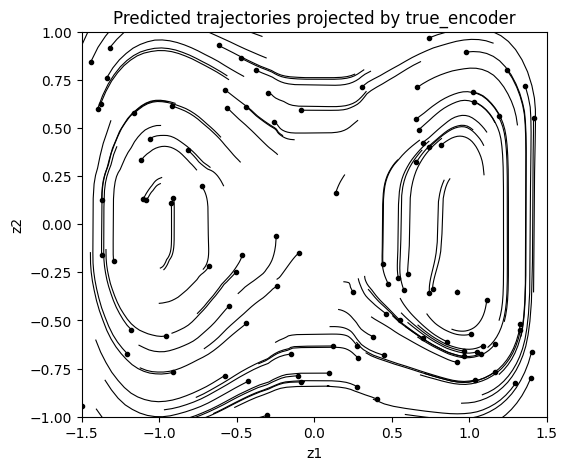

In [11]:
Zhat = true_encoder(Xhat, Amap)

plt.figure(figsize=(6, 5))
for i in range(Zhat.shape[0]):
    plt.plot(Zhat[i, 0, 0], Zhat[i, 0, 1], "ko", markersize=3)
    plt.plot(Zhat[i, :, 0], Zhat[i, :, 1], "k", linewidth=0.8)

plt.xlim([-1.5, 1.5])
plt.ylim([-1, 1])
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Predicted trajectories projected by true_encoder")
plt.show()


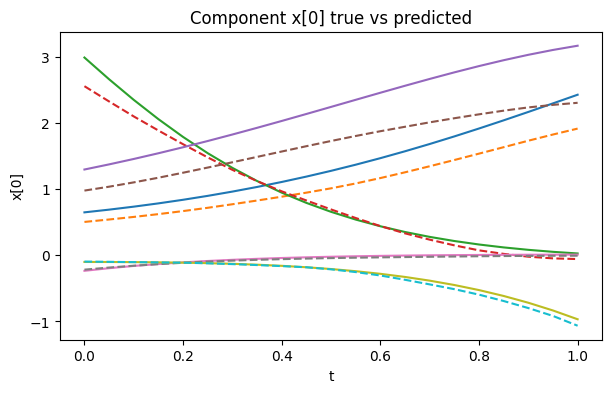

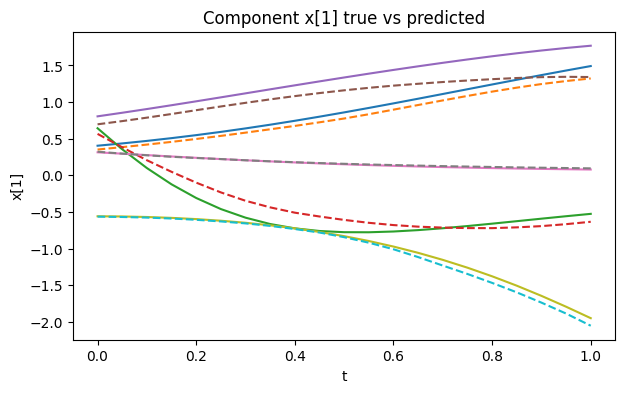

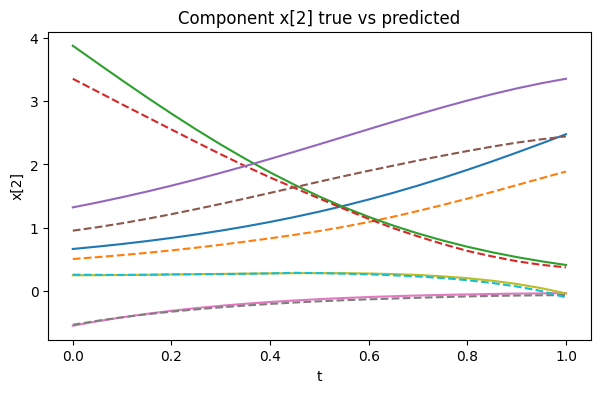

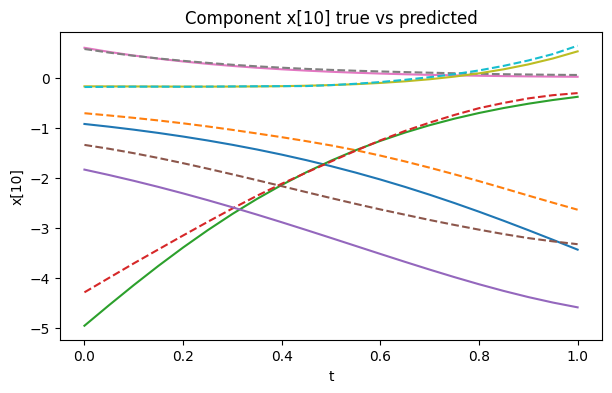

In [12]:
# Plot a few state components to sanity check (pick a few dimensions)
dims = [0, 1, 2, 10]
nplot = 5

t = t_test
for d in dims:
    plt.figure(figsize=(7,4))
    for i in range(nplot):
        plt.plot(t, Xtest[i, :, d], "-", label=f"true {i}" if d==dims[0] else None)
        plt.plot(t, Xhat[i,  :, d], "--", label=f"pred {i}" if d==dims[0] else None)
    plt.xlabel("t")
    plt.ylabel(f"x[{d}]")
    plt.title(f"Component x[{d}] true vs predicted")
    plt.show()
